In [125]:
import requests
from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup
from requests_ntlm import HttpNtlmAuth
import re
import urllib
import lxml.html
import os, sys, json
import pandas as pd
import numpy as np
import urllib
from watson_developer_cloud import ToneAnalyzerV3
from sklearn.preprocessing import MinMaxScaler

In [153]:
def lyricwikia(title,artist_name):
    url = "http://lyrics.wikia.com/wiki/"+artist_name+":"+title
    page = requests.get(url)
    lyrics = []

    soup = BeautifulSoup(page.text, 'lxml')

    m = soup.find(class_='lyricbox')

    paragraphs = re.findall(r'<div class="lyricbox">(.*?)<div class="lyricsbreak">', str(soup))
    p = paragraphs[0]

    new_text = re.sub('<br/>', '\n', p)
    return new_text

In [127]:
def get_playlist_tones(playlist):#top_songs):
    play = []
    for i in range(len(playlist)):
    #for i in range(60): #taking the first 60 songs here for the playlist
        artist_name= playlist[i][1]#top_songs.iloc[i, 2]
        title = playlist[i][0]#top_songs.iloc[i, 3]
        try:
            lyr = lyricwikia(title,artist_name)
        except:
            print("\nSONG NOT FOUND\n")
            continue
        tone_analyzer = ToneAnalyzerV3(
            version='2019-02-17',
            iam_apikey='6zSlji48p8DDphjnF_ZgfuU4pyP5PlXCk7LOEZq-YieR',
            url='https://gateway-lon.watsonplatform.net/tone-analyzer/api'
        )
        text = lyr
        if(len(lyr)==0):
            continue
        tone_analysis = tone_analyzer.tone(
            {'text': text},
            'application/json'
        ).get_result()
        print(i)
        tone = tone_analysis['document_tone']['tones']
        play.append([artist_name, title, tone])
    return play

In [128]:
def find_nearest(array, value, n):
    array = np.asarray(array)
    ele=[]
    #print("In nearest")
    for i in range(n):
        #print(i)
        idx = (np.abs(array - value)).argmin()
        if(idx not in ele):
            ele.append(idx)
        else:
            i=i-1
        alist = list(array)
        alist.remove(array[idx])
        array = np.asarray(alist)
    print("NEAREST ELEMENTS TO ZERO:",ele)
    return ele

In [129]:
def diff_matrix(data, hi_tones):
    hi = np.array(hi_tones)
    diff = data[:,hi[:,0].astype(int)] - hi[:,2].astype(float)
    print("DIFFERENCE:",diff)
    return diff

In [130]:
def plot_playlist(dkeys, avg_norm_playlist):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))  # width:20, height:3
    plt.bar(dkeys,avg_norm, align='edge', width=0.7)
    #plt.bar(dkeys,year_t[0], align='center', alpha=0.5)
    plt.xticks(dkeys)
    plt.ylabel('Score')
    plt.xlabel('Tone')
    plt.title("Playlist")
    plt.savefig("fig.png", bbox_inches='tight')
    plt.show()

In [142]:
#playlist = [["Closer" ,"The Chainsmokers"],["Body Like A Back Road","Sam Hunt"],["Believer","Imagine Dragons"],["Congratulations","Post Malone"],["Say You Won't Let Go","James Arthur"]]
#playlist = [["Treat You Better" ,"Shawn Mendes"],["A Thousand Years","Christina Perri"],["Hello","Adele"],["My Heart Will Go On","Celine Dion"],["Say You Won't Let Go","James Arthur"]]
playlist = [["Happy" ,"Pharrell Williams"],["Party In The USA","Miley Cyrus"],["The Lazy Song","Bruno Mars"],["I Gotta Feeling","Black Eyed Peas"],["Yeah!","Usher"]]

# format playlist:

In [143]:
# PLAYLIST FROM USER-----top_songs = pd.read_csv("song_fulldata.csv")
play = get_playlist_tones(playlist) #get formatted playlist+scores
playlist = pd.DataFrame(play)
playlist = np.array(playlist)
zeros_playlist = np.concatenate((playlist,np.zeros([playlist.shape[0],7])),axis = 1)
dkeys = ['anger', 'fear', 'joy', 'sadness', 'analytical', 'confident']
for i in range(zeros_playlist.shape[0]):
    sc = zeros_playlist[i][2]
    for j in range(len(sc)):
        ind = dkeys.index(sc[j]['tone_id'])
        zeros_playlist[i][ind+3] = sc[j]['score']
final_playlist = np.delete(zeros_playlist, [2],1) #final playlist with scores

0
1
2
3
4


In [144]:
final_playlist = np.array(final_playlist)
final_playlist = final_playlist[:,:-1]
print(final_playlist)

[['Pharrell Williams' 'Happy' 0.0 0.0 0.0 0.0 0.890923 0.0]
 ['Miley Cyrus' 'Party In The USA' 0.0 0.0 0.0 0.0 0.0 0.0]
 ['Bruno Mars' 'The Lazy Song' 0.517915 0.0 0.0 0.514931 0.0 0.0]
 ['Black Eyed Peas' 'I Gotta Feeling' 0.0 0.0 0.0 0.0 0.0 0.0]
 ['Usher' 'Yeah!' 0.0 0.673079 0.624373 0.0 0.0 0.0]]


In [146]:
data = pd.read_csv("output_with_song.csv")
data = data.iloc[:,1:]
minmax = MinMaxScaler()
scaled_X = minmax.fit_transform(data.iloc[:, 3:-1])
scaled_play = minmax.transform(final_playlist[:,2:])
temp = sum(scaled_play)/scaled_play.shape[0]
avg_norm = temp.copy()
sorte = np.sort(avg_norm)
max3 = sorte[-3:]
hi_tones = []
for i in max3:    
    hi_tones.append([list(avg_norm).index(i),dkeys[list(avg_norm).index(i)],i])
print(hi_tones)

[[2, 'joy', 0.12487459999999999], [1, 'fear', 0.14458741571199332], [4, 'analytical', 0.18244599101206888]]


DIFFERENCE: [[-0.1248746   0.39794487  0.33425356]
 [ 0.3974934  -0.14458742 -0.18244599]
 [-0.1248746  -0.14458742 -0.18244599]
 ...
 [ 0.4852874  -0.14458742 -0.18244599]
 [ 0.5273754  -0.14458742 -0.18244599]
 [-0.1248746  -0.14458742 -0.18244599]]
NEAREST ELEMENTS TO ZERO: [1064, 1684, 1166, 1459, 1327]
['anger', 'fear', 'joy', 'sadness', 'analytical', 'confident']
RESULTS:
[0.11097873 0.14458742 0.1248746  0.1029862  0.18244599 0.        ]


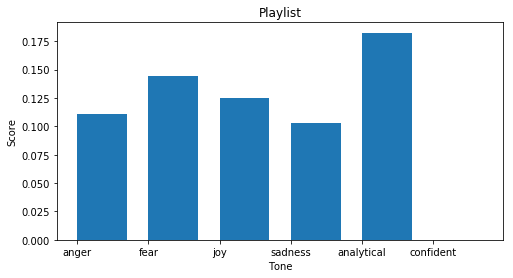

,1,2,3,4,5,6,7,8,9
1064,OneRepublic,Secrets,0.0,0.0,0.500264,0.00000,0.0,0.903862,0.000000
1684,Fifth Harmony,All In My Head,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1166,David Guetta,Who's That Chick?,0.0,0.0,0.000000,0.51399,0.0,0.000000,0.775112
1459,Hozier,Take Me To Church,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1327,Psy,Gangnam Style,0.0,0.0,0.694760,0.00000,0.0,0.000000,0.000000


In [149]:
%matplotlib inline
dkeys = ['anger', 'fear', 'joy', 'sadness', 'analytical', 'confident']
diff = diff_matrix(scaled_X, hi_tones)
#print(np.sum(diff, axis = 1))
diff_sums = np.sum(diff, axis = 1)
nearest_val = find_nearest(diff_sums, 0.0 ,5)
#print(nearest_val)
#ind_nearest=[]
#for i in nearest_val:
#    ind_nearest.append(list(diff_sums).index(i))
#print(ind_nearest)
print(dkeys)
print("RESULTS:")
print(avg_norm)
plot_playlist(dkeys, avg_norm)
data.iloc[nearest_val,1:]